In [14]:
import tensorflow as tf
import logging

import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow.keras.preprocessing.image import ImageDataGenerator

logger =  tf.get_logger()
logger.setLevel(logging.ERROR)

# Retrieve dataset

In [15]:
URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filtered.zip', origin=URL, extract=True)

In [16]:
zip_dir_base = os.path.dirname(zip_dir)
!find $zip_dir_base -type d -print

/root/.keras/datasets
/root/.keras/datasets/cats_and_dogs_filtered
/root/.keras/datasets/cats_and_dogs_filtered/validation
/root/.keras/datasets/cats_and_dogs_filtered/validation/cats
/root/.keras/datasets/cats_and_dogs_filtered/validation/dogs
/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/train/cats
/root/.keras/datasets/cats_and_dogs_filtered/train/dogs


In [17]:
base_dir = os.path.join(zip_dir_base, 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Data Analysis

## Count the dataset


In [18]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))
num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

num_tr_total = num_cats_tr + num_dogs_tr
num_val_total = num_cats_val + num_dogs_val

In [19]:
print("Training Set] CATS:", num_cats_tr)
print("Training Set] DOGS:", num_dogs_tr)
print("Validation Set] CATS:", num_cats_val)
print("Validation Set] DOGS:", num_dogs_val)
print("===================")
print("Training Set:", num_tr_total)
print("Validation Set:", num_val_total)

Training Set] CATS: 1000
Training Set] DOGS: 1000
Validation Set] CATS: 500
Validation Set] DOGS: 500
Training Set: 2000
Validation Set: 1000


## Load the dataset

In [20]:
BATCH_SIZE = 100
TARGET_IMAGE_SHAPE = (150, 150)

train_image_generator = ImageDataGenerator(
                          rescale=1./255,
                          rotation_range=45,
                          horizontal_flip=True,
                          width_shift_range=0.2,
                          height_shift_range=0.2,
                          zoom_range=0.5
                        )
train_data_generator = train_image_generator.flow_from_directory(batch_size=BATCH_SIZE, 
                                                                 directory=train_dir,
                                                                 shuffle=True, 
                                                                 target_size=TARGET_IMAGE_SHAPE, 
                                                                 class_mode='binary')

test_image_generator = ImageDataGenerator(rescale=1./255)
test_data_generator = test_image_generator.flow_from_directory(directory=validation_dir,
                                                               batch_size=BATCH_SIZE,
                                                               shuffle=False,
                                                               target_size=TARGET_IMAGE_SHAPE,
                                                               class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Peek at the data

In [21]:
sample_images,_ = next(train_data_generator)
sample_images.shape
train_data_generator.reset()

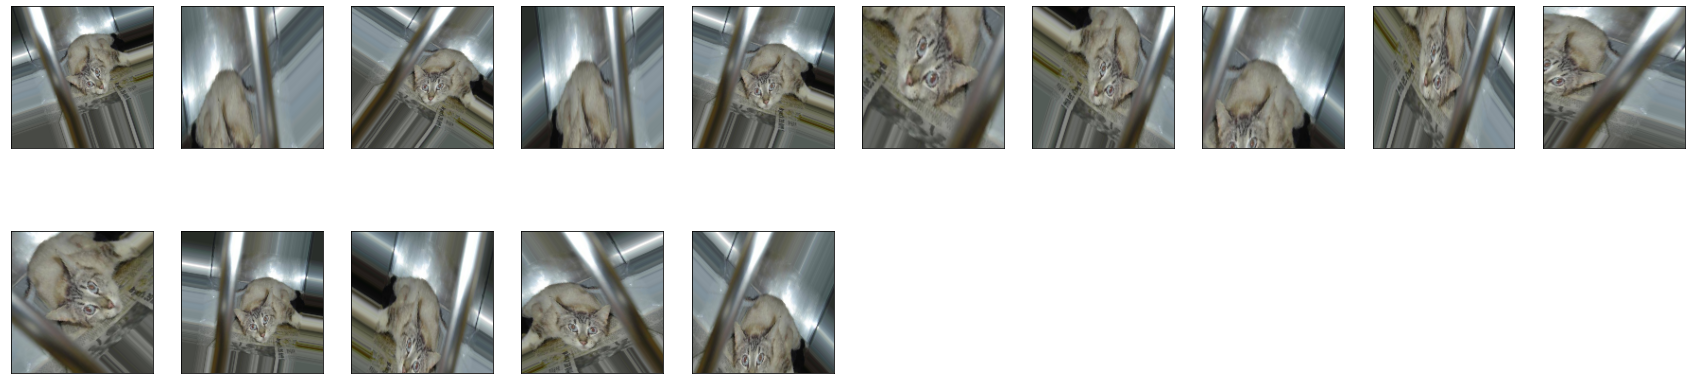

In [22]:
plt.figure(figsize=(30, 20))

augmented_images = [train_data_generator[0][0][0] for i in range(15)]

for index,image in enumerate(augmented_images):
  plt.subplot(5, 10, index+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(image)

#Model

In [23]:
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
  tf.keras.layers.MaxPooling2D(2,2),
  
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),

  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),

  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(2, activation='softmax')
]);

model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics='accuracy')

In [24]:
EPOCHS = 200
history = model.fit_generator(
    generator=train_data_generator, 
    epochs=EPOCHS, 
    steps_per_epoch=np.ceil(num_tr_total/BATCH_SIZE),
    validation_data=test_data_generator,
    validation_steps=np.ceil(num_val_total/BATCH_SIZE)
)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/200


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


20/20 [==============================] - 17s 810ms/step - loss: 0.7318 - accuracy: 0.5075 - val_loss: 0.6911 - val_accuracy: 0.5000
Epoch 2/200
20/20 [==============================] - 16s 800ms/step - loss: 0.6929 - accuracy: 0.4960 - val_loss: 0.6915 - val_accuracy: 0.5250
Epoch 3/200
20/20 [==============================] - 16s 801ms/step - loss: 0.6905 - accuracy: 0.5245 - val_loss: 0.6821 - val_accuracy: 0.6320
Epoch 4/200
20/20 [==============================] - 16s 781ms/step - loss: 0.6830 - accuracy: 0.5545 - val_loss: 0.6743 - val_accuracy: 0.5910
Epoch 5/200
20/20 [==============================] - 15s 764ms/step - loss: 0.6883 - accuracy: 0.5700 - val_loss: 0.6869 - val_accuracy: 0.5100
Epoch 6/200
20/20 [==============================] - 15s 766ms/step - loss: 0.6777 - accuracy: 0.5895 - val_loss: 0.6713 - val_accuracy: 0.5580
Epoch 7/200
20/20 [==============================] - 15s 764ms/step - loss: 0.6551 - accuracy: 0.6165 - val_loss: 0.6918 - val_accuracy: 0.5690
Epoc

Text(0.5, 1.0, 'Loss')

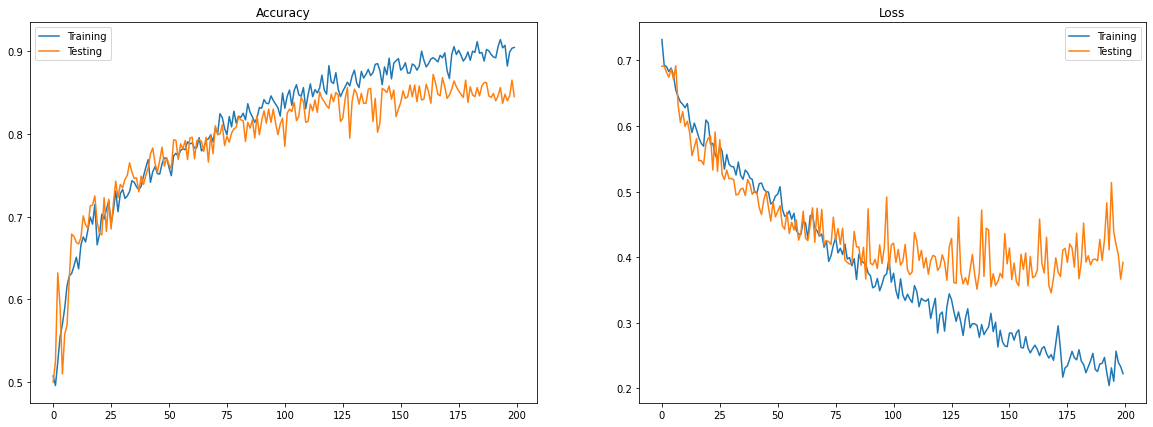

In [25]:
plt.figure(figsize=(20, 7))

plt.subplot(1,2,1)
plt.plot(history.epoch, history.history['accuracy'], label='Training')
plt.plot(history.epoch, history.history['val_accuracy'], label='Testing')
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.epoch, history.history['loss'], label='Training')
plt.plot(history.epoch, history.history['val_loss'], label='Testing')
plt.legend()
plt.title("Loss")